In [0]:
!pip install pyspellchecker
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
%tensorflow_version 2.x
!pip install sentencepiece

     |████████████████████████████████| 1.9MB 9.5MB/s 
TensorFlow 2.x selected.
     |████████████████████████████████| 1.0MB 8.5MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import re
from spellchecker import SpellChecker
import string
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
import tensorflow_hub as hub
import tokenization

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import data

In [0]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle_NLP/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle_NLP/test.csv')
df_sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle_NLP/sample_submission.csv')

# EDA

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [0]:
print('Shape of df_train {}'.format(df_train.shape))
print('Shape of df_test {}'.format(df_test.shape))


Shape of df_train (7613, 5)
Shape of df_test (3263, 4)


In [0]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Missing Values

In [0]:
def check_missing(df,cols=None,axis=0):
  if cols!=None:
    df=df[cols]
  missing = df.isnull().sum(axis).to_frame()
  missing['missing_percent']=df.isnull().mean(axis)
  return missing.sort_values(by='missing_percent',ascending = False) 

In [0]:
check_missing(df_train)

,0,missing_percent
location,2533,0.332720
keyword,61,0.008013
id,0,0.000000
text,0,0.000000
target,0,0.000000


In [0]:
check_missing(df_test)

,0,missing_percent
location,1105,0.338645
keyword,26,0.007968
id,0,0.000000
text,0,0.000000


## Class distribution

Text(0, 0.5, 'Frequency')

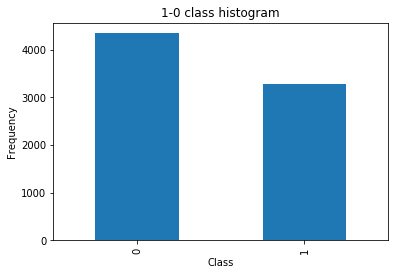

In [0]:
pd.value_counts(df_train['target']).plot.bar()
plt.title('1-0 class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

## Data Cleaning

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [0]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [0]:
def remove_stopwords(text):
  stopWords = set(stopwords.words('english'))
  tokens = word_tokenize(text)
  tokens = [w for w in tokens if not w in stopWords]
  text=' '.join(tokens)
  return text


In [0]:
# Thanks to https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data - 
# author of this kernel read tweets in training data and figure out that some of them have errors:

ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
df_train.loc[df_train['id'].isin(ids_with_target_error),'target'] = 0
df_train[df_train['id'].isin(ids_with_target_error)]

,id,keyword,location,text,target
229,328,annihilated,NaN,Ready to get annihilated for the BUCS game,0
301,443,apocalypse,NaN,Short Reading\n\nApocalypse 21:1023 \n\nIn the...,0
356,513,army,Studio,But if you build an army of 100 dogs and their...,0
1822,2619,crashed,NaN,My iPod crashed..... \n#WeLoveYouLouis \n#MTVH...,0
2536,3640,desolation,"Quilmes , Arg",This desperation dislocation\nSeparation conde...,0
2715,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,0
3024,4342,dust%20storm,chicago,Going to a fest? Bring swimming goggles for th...,0
4068,5781,forest%20fires,NaN,Campsite recommendations \nToilets /shower \nP...,0
4609,6552,injury,Saint Paul,My prediction for the Vikings game this Sunday...,0
4611,6554,injury,NaN,Dante Exum's knee injury could stem Jazz's hop...,0


In [0]:
def data_cleaning(df,col='text'):
  df[col]=df[col].map(lambda x:remove_URL(x))\
  .map(lambda x:remove_html(x))\
  .map(lambda x:remove_emoji(x))\
  .map(lambda x:remove_punct(x))\
  .map(lambda x:convert_abbrev_in_text(x))\
  .map(lambda x:remove_stopwords(x))
  


In [0]:
data_cleaning(df_train)

In [0]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked shelter place notified off...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1


# BERT

In [0]:
%%time
bert_layer = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1',
    trainable=True
)

CPU times: user 21.7 s, sys: 4.21 s, total: 25.9 s
Wall time: 45.8 s


In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
max_len = 160

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

train_input = bert_encode(df_train.text.values, tokenizer, max_len=max_len)
train_labels = df_train.target.values

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=12
)

model.save('model.h5')

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 453s 74ms/sample - loss: 0.4393 - accuracy: 0.8061 - val_loss: 0.3897 - val_accuracy: 0.8339
Epoch 2/5
6090/6090 [==============================] - 421s 69ms/sample - loss: 0.2683 - accuracy: 0.8926 - val_loss: 0.4376 - val_accuracy: 0.8214
Epoch 3/5
6090/6090 [==============================] - 421s 69ms/sample - loss: 0.1162 - accuracy: 0.9563 - val_loss: 0.5779 - val_accuracy: 0.8181
Epoch 4/5
6090/6090 [==============================] - 421s 69ms/sample - loss: 0.0695 - accuracy: 0.9749 - val_loss: 0.6564 - val_accuracy: 0.8286
Epoch 5/5
6090/6090 [==============================] - 421s 69ms/sample - loss: 0.0489 - accuracy: 0.9782 - val_loss: 0.7367 - val_accuracy: 0.8201


# Prediction test

In [0]:
data_cleaning(df_test)

In [0]:
test_input = bert_encode(df_test.text.values, tokenizer, max_len=max_len)

In [0]:
test_pred = model.predict(test_input)

In [0]:
df_sample['target']=test_pred.round().astype(int)

In [0]:
df_sample.to_csv('/content/drive/My Drive/Colab Notebooks/Kaggle_NLP/submission.csv', index=False)